In [ ]:
import json

ideas_file = 'sample_ideas/agentic_ai_for_idea_generation_ideas.json'

with open(ideas_file, 'r') as f:
    ideas_data = json.load(f)

for ideas in ideas_data['ideas']:
    for idea, items in ideas.items():
        print(idea)
        for item, i in items.items():
            print(f"- {item}")

In [85]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
# from langchain.prompts import ChatPromptTemplate

from typing import Literal
from dotenv import load_dotenv
import json
import os 

load_dotenv()



True

In [101]:

llm = ChatOpenAI(
    temperature=0,  # Set the temperature for the model's responses
    model_name="gpt-5-nano",  # Specify the model name
    openai_api_key=os.getenv("OPENAI_API_KEY")
)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite",
                             google_api_key=os.getenv("GOOGLE_API_KEY"))


In [88]:
## Testing LLM Call

# 
messages = [
    SystemMessage(content="You are a helpful assistant"),
    HumanMessage(content="Tell me about Python programming in one sentence")
]
response = llm.invoke(messages)
print(response.content)


Python is a high-level, versatile programming language renowned for its simple, readable syntax that enables rapid development for everything from web applications to data science.


## Retrieve Paper with SemanticScholar

In [26]:
import requests


class getReferencePaper():
    def __init__(self):
        self.api_key = os.getenv("SEMANTIC_SCHOLAR_API_KEY")


    def query_search(self, query):
        url="https://api.semanticscholar.org/graph/v1/paper/search/"
        
        query_params = {
            "query": query,
            "fields": "title,citationCount,tldr,url,publicationTypes,publicationDate,openAccessPdf,abstract",
            "year": "2020-2025",
            "limit": 50,
            "sort": "relevance",
            "minCitationCount": 10
        }
        headers = {"x-api-key": self.api_key}
        response = requests.get(url, params=query_params, headers=headers).json()
        
        return response

    def PaperDetails(self, paper_id, fields="title,year,abstract,authors,citationCount,venue,citations,references,tldr"):
        
        url = "https://api.semanticscholar.org/graph/v1/paper/"
        
        paper_data_query_params = {"fields": fields}
        headers = {"x-api-key": self.api_key}
        response = requests.get(
            url = url + paper_id, params=paper_data_query_params, headers=headers
        )
        
        return response.json()
    
    @staticmethod
    def prepare_papers_for_llm(list_of_papers):
        unique_papers = {}

        for query_string, query_data in list_of_papers.items():
            for paper in query_data.get('data', []):
                paper_id = paper.get('paperId')
                if paper_id and paper_id not in unique_papers:  # Skips if paper_id is None
                    paper_str = f"""Paper ID: {paper_id}
                                    Title: {paper.get('title')}
                                    Abstract: {paper.get('abstract')}
                                """
                    unique_papers[paper_id] = paper_str
                    
        paper_list = list(unique_papers.values())
                
        papers_for_llm = "\n\n---\n\n".join(paper_list)
        return papers_for_llm

 
# query = 'Computing Machinery and Intelligence'

# search_paper = getReferencePaper()
# search_paper_response = search_paper.query_search(query)




## Graph

### Agent 1: Idea Parser

In [27]:
from typing import Optional, List, Dict
from pydantic import BaseModel, Field, field_validator


class IdeaParser(BaseModel):
    """
    Agent 1: Parse Idea from user input into structured format.
    1. Extract ideas from the user's input.
    """
    research_question: str = Field(
        description="The main research question in one conscise sentence"
    )
    
    problem_domain: str = Field(
        description="The specific problem domain or area of interest related to the research question. (e.g., natural language processing, computer vision, etc.)"
    )
    
    methodology_keywords: List[str] = Field(
        description="A list of technical keywords mentioned in the methods"
    )
    
    key_concepts: List[str] = Field(
        description="A list of key concepts or theories relevant to the research question and problem domain."
    )
    
    existing_methods: List[str] = Field(
        description="A list of existing methods or approaches mentioned in the user's input that are relevant to the research question and problem domain."
    )
    
    claimed_novelty: List[str] = Field(
        description="A list of claimed novel aspects or contributions inferred from the user's input."
    )
    
    
    
    @field_validator('key_concepts')
    @classmethod
    def validate_key_concepts_counts(cls, v):
        """Ensure that there are a reasonable number of key concepts extracted"""
        if len(v) < 3 or len(v) > 15:
            raise ValueError('At least 3 and at most 15 key concepts are required.')
        return v

    def to_dict(self) -> Dict:
        return self.model_dump()
    
    def to_summary(self) -> str:
        return f"""Research Question: {self.research_question}\n
                    Problem Domain: {self.problem_domain}\n
                    Key Concepts: {', '.join(self.key_concepts)}\n
                    Claimed Novelty: {', '.join(self.claimed_novelty)}"""

In [28]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

idea_parser_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a research analysis assistant that has a deep understanding of extracting structured information from research proposals.

            INPUT:
            You will receive a research idea description with these fields:
            - Problem: The research problem being addressed
            - Existing Methods: Current approaches and their limitations
            - Motivation: Why this research is needed
            - Proposed Method: The new approach being proposed
            - Experiment Plan: How the approach will be evaluated

            YOUR TASK:
            Extract and structure the key information needed for finding similar work.

            OUTPUT REQUIREMENTS:
            Return ONLY valid JSON with NO additional text, markdown formatting, or code blocks.
            Do not include ```json or ``` markers.
            Your entire response must be parseable by JSON.parse().

            CRITICAL: Be precise and specific in extraction. Extract actual technical terms, not generic descriptions.

            OUTPUT SCHEMA:
            {{
            "research_question": "string - The main research question in one concise sentence",
            "problem_domain": "string - The specific research area/field (e.g., 'natural language processing', 'computer vision')",
            "methodology_keywords": [
                "string - Specific technical methods mentioned (e.g., 'reinforcement learning', 'transformer architecture')"
            ],
            "key_concepts": [
                "string - Core concepts and techniques (e.g., 'prompt optimization', 'context window management')"
            ],
            "existing_methods_mentioned": [
                "string - Baseline methods or prior work explicitly mentioned"
            ],
            "claimed_novelty_aspects": [
                "string - What the proposal claims is novel (extract from Motivation and Proposed Method)"
            ]
            }}

            EXTRACTION RULES:
            1. Be specific: Extract "transformer architecture" not "neural network"
            2. Preserve technical terms exactly as written
            3. For methodology_keywords: Include only actionable technical terms
            4. For key_concepts: Include 5-8 most important concepts
            5. For claimed_novelty_aspects: Extract 2-4 specific novel claims
            6. If a field has no relevant information, use empty array [] or empty string ""

            RESEARCH IDEA:
            {research_idea}

            OUTPUT (valid JSON only):
            """,
        ),
        # MessagesPlaceholder(variable_name="messages"),  # Placeholder for dynamic messages
    ])


# Create the writer agent by binding the prompt template and language model
idea_parser_agent = idea_parser_prompt |  llm.with_structured_output(IdeaParser)



In [29]:
def call_idea_parser(state: MessagesState):
    user_message = state["messages"][-1]  # HumanMessage
    
    # Invoke the agent chain
    response = idea_parser_agent.invoke({
        "research_idea": user_message.content
    })
    # response is now an IdeaParser object
    
    return {"messages": [AIMessage(content=json.dumps(response.to_dict(), indent=2))]}


### Agent 2: Literature Retrieval

In [30]:
class QueryGenerator(BaseModel):
    """
    Agent 2: Generate Search Queries from parsed research idea.
    1. Create effective search queries to find related work.
    """
    query_string: str = Field(
        description="Search query to be passed to the API"
    )
    
    rationale: str = Field(
        description="Rationale for why this query will find relevant papers"
    )
    
    priority_concept: str = Field(
    description="The most important concept to focus on in the search"
    )
    
    @field_validator('query_string')
    @classmethod
    def validate_query_string_length(cls, v):
        """Ensure that the query is not too long"""
        if len(v.split()) > 8:
            raise ValueError('Query string must be less than 8 words.')
        return v

    def to_dict(self) -> Dict:
        return self.model_dump()
    
class QueryGeneratorOutput(BaseModel):
    """Multiple search queries"""
    queries: List[QueryGenerator] = Field(
        description="List of 5 diverse search queries"
    )
    
    def to_dict(self) -> Dict:
        return {
            "queries": [q.to_dict() for q in self.queries]
        }
    




In [31]:

query_generator_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced professor with an established search query strategy skill for academic literature databases.

            CONTEXT:
            You have a parsed research idea and need to generate optimal search queries for Semantic Scholar API.
            Your queries will retrieve papers to assess the novelty of the proposed research.

            PARSED RESEARCH IDEA:
            {parsed_idea_json}


            YOUR TASK:
            Generate 5 (five) diverse search queries that will find the most relevant existing work.


            QUERY OPTIMIZATION RULES:
            1. Keep queries SHORT: 2-6 words maximum for best results
            2. Use technical terms, not natural language
            3. Combine 2-3 concepts maximum per query
            4. NO operators: Don't use "AND", "OR", "-", quotes, or "site:"
            5. Prioritize precision over recall

            OUTPUT REQUIREMENTS:
            Return ONLY valid JSON with NO additional text or formatting.
            Do not include ```json or ``` markers.

            OUTPUT SCHEMA:
            {{
            "queries": [
                {{
                "query_string": "string - The actual search query (2-6 words)",
                "rationale": "string - Why this query will find relevant papers",
                "priority_concepts" : "string - Top 3-5 concepts that should appear in similar papers"
                }}
            ]
            }}

            EXAMPLES OF GOOD QUERIES:
            - "adaptive prompt dialogue coherence"
            - "dynamic context management LLM"
            - "conversational continuity language models"
            - "iterative prompt optimization"

            EXAMPLES OF BAD QUERIES:
            - "papers about improving language model coherence" (too natural language)
            - "dynamic AND adaptive OR iterative -static" (operators not supported)
            - "comprehensive survey of prompt engineering techniques" (too long/broad)

            OUTPUT (valid JSON only):""",
        ),
        # MessagesPlaceholder(variable_name="messages"),  # Placeholder for dynamic messages
    ])


query_generator_agent = query_generator_prompt |  llm.with_structured_output(QueryGeneratorOutput)



In [32]:
def call_query_generator(state: MessagesState):
    last_message = state["messages"][-1]  # HumanMessage
    
    # Invoke the agent chain
    response = query_generator_agent.invoke({
        "parsed_idea_json":last_message.content #json.dumps(json.loads(last_message.content))
    })
    # response is now an IdeaParser object
    
    return {"messages": [AIMessage(content=json.dumps(response.to_dict(), indent=2))]}


#### AGENT 3 : search paper using semantic scholar api

In [33]:
def call_paper_search(state: MessagesState):
    last_message = state["messages"][-1]  # LastMessage
    queries_json = json.loads(last_message.content)
    all_search_results = {}
    
    search_paper = getReferencePaper()

    
    for search_query in queries_json['queries']:
        query_string = search_query['query_string']
        search_results = search_paper.query_search(query_string)
        all_search_results[query_string] = search_results
    
    return {"messages": [AIMessage(content=json.dumps(all_search_results, indent=2))]}

### Agent 4 : Score

In [34]:
class PaperAnalyzer(BaseModel):
    """
    Agent 2: Generate Search Queries from parsed research idea.
    1. Create effective search queries to find related work.
    """
    paper_id: str = Field(
        description="semantic scholar paper ID to be analyzed"
    )
    
    title: str = Field(
        description="Title of the paper to be analyzed"
    )
    
    overlap_score: float = Field(
        description="float 0.0-1.0 - overlap similarity with proposed idea"
    )
    
    methodology_overlap: float = Field(
        description="score 0 - 1. Methodology overlap with the proposed idea (inferring from abstract and title)"
    )
    
    problem_overlap: float = Field(
        description="score 0 - 1. Problem overlap with the proposed idea (inferring from abstract and title)"
    )
    
    domain_overlap: float = Field(
        description="score 0 - 1. Domain overlap with the proposed idea (inferring from abstract and title)"
    )   
    key_overlaps: List[str] = Field(
        description="Specific overlapping aspects"
    )
    
    key_differences: List[str] = Field(
        description="How proposed idea differs"
    )

    def to_dict(self) -> Dict:
        return self.model_dump()
    
class PaperAnalyzerOutput(BaseModel):
    """Multiple search queries"""
    queries: List[PaperAnalyzer] = Field(
        description="List of all analyzed papers"
    )
    
    def to_dict(self) -> Dict:
        return {
            "papers": [q.to_dict() for q in self.queries]
        }
    
    
    

In [35]:


prior_work_analysis_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experience researcher with years of expertise in academic literature review and analysis.

                PROPOSED RESEARCH IDEA:
                {research_idea}
                
                LIST OF RETRIEVED PAPERS:
                {paper_list}
                
                YOUR TASK:
                For each paper, assess the degree of overlap with the proposed research idea.
                
                ANALYSIS CRITERIA:
                Methodology overlap: Do they use similar approaches?
                Problem overlap: Do they address the same problem?
                Domain overlap: Same application area?
                Overall score: The average of the three overlap scores.
                
                OUTPUT REQUIREMENTS:
                Return ONLY valid JSON with NO additional text.
                Do not include ```json or ``` markers.
                
                OUTPUT SCHEMA:
                {{
                "paper_analyses": [
                   {{
                      "paper_id": "string - Semantic Scholar paper ID",
                      "title": "string",
                      "overlap_score": "float 0.0-1.0 - Overall similarity",
                      "methodology_overlap": "float 0.0-1.0",
                      "problem_overlap": "float 0.0-1.0", 
                      "domain_overlap": "float 0.0-1.0",
                      "key_overlaps": [
                        "string - Specific overlapping aspects"
                      ],
                      "key_differences": [
                        "string - How proposed idea differs"
                      ]
                    }}
                  ]
                }}
                
                SCORING GUIDELINES:
                overlap_score 0.8-1.0: Nearly identical approach
                overlap_score 0.6-0.8: High similarity, incremental difference
                overlap_score 0.4-0.6: Moderate similarity, related work
                overlap_score 0.2-0.4: Tangentially related
                overlap_score 0.0-0.2: Different approach, same domain
                
                Be precise and evidence-based. Cite specific aspects from paper titles/abstracts.
                
                OUTPUT (valid JSON only):
                
            """,
        ),
        # MessagesPlaceholder(variable_name="messages"),  # Placeholder for dynamic messages
    ])

prior_work_analysis_agent = prior_work_analysis_prompt |  llm.with_structured_output(PaperAnalyzerOutput)

In [36]:
def call_prior_work_analysis(state: MessagesState):
    last_message = state["messages"][-1]  # HumanMessage
    initial_user_input = state["messages"][0]  # Research idea
    
    
    list_of_papers = getReferencePaper.prepare_papers_for_llm(
        json.loads(last_message.content)
    )
    
    # Invoke the agent chain
    response = prior_work_analysis_agent.invoke({
        "research_idea":initial_user_input.content, #json.dumps(json.loads(last_message.content)),
        "paper_list": list_of_papers
    })
    # response is now an IdeaParser object
    
    return {"messages": [AIMessage(content=json.dumps(response.to_dict(), indent=2))]}


### Experiments

In [37]:
workflow = StateGraph(MessagesState)

workflow.add_node("idea_parser", call_idea_parser)
workflow.add_node("search_query", call_query_generator)
workflow.add_node("search_paper", call_paper_search)
workflow.add_node("prior_work_analysis", call_prior_work_analysis)

workflow.add_edge(START, "idea_parser")
workflow.add_edge("idea_parser", "search_query")
workflow.add_edge("search_query", "search_paper")
workflow.add_edge("search_paper", "prior_work_analysis")
workflow.add_edge("prior_work_analysis", END)

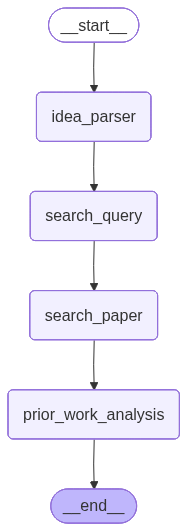

In [38]:
from IPython.display import Image, display

graph = workflow.compile()
# graph.get_graph().draw_mermaid_png(output_file_path='story.png')
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
graph = workflow.compile()
graph.get_graph().draw_mermaid_png(output_file_path='story.png')

result_llm = graph.invoke(
    {
        "messages": [
            (
                "user",
                """Dynamic Prompt Adaptation:
                Problem: Large Language Models (LLMs) often struggle with maintaining coherence over extended interactions or creative tasks, leading to thematic inconsistencies and reduced reader engagement.
                Existing Methods: Current methods often use fixed prompts or few-shot examples, which may not adapt to the evolving context of a conversation or creative narrative. Techniques such as Chain-of-Thought prompting are utilized, but they do not inherently address continuity and adaptability across interactions.
                Motivation: Human creative writing often involves iterative dialogue and adaptation to the flow of discussion. The style and context of interactions can shift dynamically based on prior exchanges. Dynamic adaptation mirrors how authors and conversationalists adjust based on audience feedback and shifting themes.
                Proposed Method: We propose Dynamic Prompt Adaptation, involving three phases: (1) Contextual Analysis - Analyze previous outputs and user prompts to extract key themes and tonal shifts, applying a prompting structure like 'Reflect on the previous topic of [theme] and build on it.' (2) Adaptive Prompt Generation - Using insights from the analysis, generate updated prompts that introduce new elements or clarify past responses, e.g., 'Continuing from your last thought on [theme], can you expand on how this might be represented in [new context]?' (3) Iterative Context Update - As the dialogue progresses, generate a synthesis of all prior interactions to maintain thematic coherence, prompting with 'Summarize the key points discussed so far to keep track of our narrative.'
                Experiment Plan: Test against static prompting strategies by evaluating engagement scores, coherence assessments, and user satisfaction in storytelling scenarios using standard text generation metrics such as BLEU and ROUGE. Incorporate user feedback on naturalness and adaptability during the interaction. Datasets could include the 'Story Cloze Test' dataset and user-generated dialogue interactions scraped from platforms like Reddit to assess conversational engagement."""
            )
        ]
    },
    debug=True
)

[values] {'messages': [HumanMessage(content="Dynamic Prompt Adaptation:\n                Problem: Large Language Models (LLMs) often struggle with maintaining coherence over extended interactions or creative tasks, leading to thematic inconsistencies and reduced reader engagement.\n                Existing Methods: Current methods often use fixed prompts or few-shot examples, which may not adapt to the evolving context of a conversation or creative narrative. Techniques such as Chain-of-Thought prompting are utilized, but they do not inherently address continuity and adaptability across interactions.\n                Motivation: Human creative writing often involves iterative dialogue and adaptation to the flow of discussion. The style and context of interactions can shift dynamically based on prior exchanges. Dynamic adaptation mirrors how authors and conversationalists adjust based on audience feedback and shifting themes.\n                Proposed Method: We propose Dynamic Prompt A

In [133]:
list_of_papers = json.loads(result_llm["messages"][-1].content)

In [191]:
import json
import pandas as pd

# Parse the results
result_content = json.loads(result_llm["messages"][-1].content)

# Create DataFrame
papers_df = pd.DataFrame(result_content['papers'])

papers_df[["methodology_overlap","problem_overlap","domain_overlap"]]


## NOTE
## Wrong overlap calculation

### Development Note
## might be interesting to make the output of this papers analysis passed into 
## a GAN-like architecture (So not using overlapping score like the current one)
## where one agent is argumenting why the idea is novel
## and another agent is criticising why the idea is not novel, both based on the prior work
## and then another agent act as a judge to decide which argument is stronger

,methodology_overlap,problem_overlap,domain_overlap
0,0.85,0.85,0.70
1,0.84,0.82,0.78
2,0.83,0.82,0.80
3,0.70,0.70,0.75
4,0.78,0.75,0.76
5,0.72,0.68,0.65
6,0.80,0.80,0.80
7,0.72,0.70,0.70
8,0.66,0.66,0.70
9,0.68,0.70,0.72


## Evaluation Program

Notes

-> since everything here will be based on the retrieved papers, we need to make sure that the papers are retrieved correctly.


-> and also we need to limit the number of papers not to be too many that would make the system too complex.

### Adversarial GAN-like Evaluation of Research Ideas

#### Advocate Agent
The goal of the advocate agent is to defend the research idea, grounded based on the retrieved papers

In [13]:
class AdversarialAgent(BaseModel):
    """
    Base class for Adversarial Agents
    All agents must provide evidence-based arguments citing retrieved papers.
    """
    argument: str = Field(
        description="The main argument presented by the agent"
    )
    
    supporting_papers: List[str] = Field(
        description="List of paper IDs cited to support this argument",
        default_factory=list
    )
    
    key_points: List[str] = Field(
        description="Main points made in this argument",
        default_factory=list
    )

    def to_dict(self) -> Dict:
        return self.model_dump()


In [18]:
from langchain_core.prompts import ChatPromptTemplate
advocate_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are the ADVOCATE for the proposed research idea.
Your goal is to defend the idea, highlight its novelty and feasibility.
Use the provided retrieved papers to support your arguments.

Focus on:
1. Unique contributions
2. How it improves upon existing methods (cite paper IDs)
3. Why the potential impact outweighs risks

Research Idea:
{research_idea}

Retrieved Papers:
{retrieved_papers}

Provide a strong, evidence-based argument citing specific papers.
"""
    ),
    MessagesPlaceholder(variable_name="history"),  # Automatically includes message history
])

# Create advocate agent that returns structured output
class AdvocateResponse(AdversarialAgent):
    """Advocate's argument response"""
    pass

advocate_agent = advocate_prompt | llm.with_structured_output(AdvocateResponse)


In [53]:
def call_advocate_agent(state: DebateState):
    research_idea = state['research_idea']
    retrieved_papers = state['retrieved_papers']
    messages = state['messages']
    
    response = advocate_agent.invoke({
        "research_idea": research_idea,
        "retrieved_papers": retrieved_papers,
        "history": messages  # Pass the messages list directly
    })
    
    return {
        "messages": [AIMessage(content=response.argument)]
    }

#### Critics Agent
The goal of the critics agent is to challenge the idea and the advocate's argument by finding the gap or weakness in the idea.

In [54]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

skeptic_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are the SKEPTIC of the proposed research idea.
Your goal is to critique the idea, point out flaws, and question its novelty.
Use the provided retrieved papers to show similarity to prior work or identify weaknesses.

Focus on:
1. Overlaps with existing work (cite specific papers).
2. Potential technical challenges or flaws.
3. Why the idea might not be as novel or impactful as claimed.

Research Idea:
{research_idea}

Retrieved Papers:
{retrieved_papers}

Provide a critical, evidence-based counter-argument.
"""
    ),
    MessagesPlaceholder(variable_name="history"),  # Automatically includes message history
])

# Create skeptic agent that returns structured output
class SkepticResponse(AdversarialAgent):
    """Skeptic's argument response"""
    pass

skeptic_agent = skeptic_prompt | llm.with_structured_output(SkepticResponse)

def call_skeptic_agent(state: DebateState):
    research_idea = state['research_idea']
    retrieved_papers = state['retrieved_papers']
    messages = state['messages']
    
    response = skeptic_agent.invoke({
        "research_idea": research_idea,
        "retrieved_papers": retrieved_papers,
        "history": messages  # Pass the messages list directly
    })
    
    return {
        "messages": [AIMessage(content=response.argument)]
    }

#### Judge Agent
The goal of the judge agent is to be a neutral and objective evaluator between the advocate and critic agents, and to find the final verdict of the research idea.

In [70]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

moderator_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are an EXPERT guiding a debate between an Advocate and a Skeptic about a research idea.
Your goal is to synthesize the arguments, ask probing questions to clarify the idea, and ensure the discussion remains grounded in the literature.

Research Idea:
{research_idea}

Retrieved Papers:
{retrieved_papers}

Current Iteration: {iteration} / {max_iterations}

Task:
1. Summarize the key points made by both sides so far.
2. If the maximum iterations have been reached or if the discussion has converged, provide a FINAL VERDICT on the idea's novelty and feasibility. Start your response with "VERDICT:".
3. If the discussion should continue, ask a specific, probing question to guide the next round of debate.

OUTPUT (valid JSON only):

"""
    ),
    MessagesPlaceholder(variable_name="history"),  # Automatically includes message history
])

# Create moderator response that returns structured output
class ModeratorResponse(AdversarialAgent):
    """Moderator's response"""
    verdict: str = Field(
        description="Final verdict if debate concluded (starts with 'VERDICT:')",
        default=None
    )
    next_question: Optional[str] = Field(
        description="Question for next round if continuing",
        default=None
    )
    
    def to_dict(self) -> Dict:
        return self.model_dump()

moderator_agent = moderator_prompt | llm.with_structured_output(ModeratorResponse)



# def call_moderator_agent(state: DebateState):
#     research_idea = state['research_idea']
#     retrieved_papers = state['retrieved_papers']
#     messages = state['messages']
#     iteration = state.get('iteration', 0)
#     max_iterations = state.get('max_iterations', 3)
    
#     response = moderator_agent.invoke({
#         "research_idea": research_idea,
#         "retrieved_papers": retrieved_papers,
#         "iteration": iteration,
#         "max_iterations": max_iterations,
#         "history": messages  # Pass the messages list directly
#     })
    
#     # Force verdict on final iteration
#     if iteration + 1 >= max_iterations:
#         # Prepend VERDICT: if not already present
#         argument = response.argument
#         if not argument.startswith("VERDICT:"):
#             argument = f"VERDICT: {argument}"
#         return {
#             "messages": [AIMessage(content=argument)],
#             "iteration": iteration + 1
#         }
    
#     return {
#         "messages": [AIMessage(content=response.argument)],
#         "iteration": iteration + 1
#     }

class VerdictResponse(BaseModel):
    """Final verdict structure"""
    novelty_score: int = Field(description="Score 1-10 for novelty", ge=1, le=10)
    feasibility_score: int = Field(description="Score 1-10 for feasibility", ge=1, le=10)
    summary: str = Field(description="Summary of the debate")
    strengths: List[str] = Field(description="Key strengths identified")
    weaknesses: List[str] = Field(description="Key weaknesses identified")
    recommendation: str = Field(description="Accept/Revise/Reject with justification")
    
    def to_verdict_text(self) -> str:
        return f"""VERDICT: Research Idea Evaluation

SCORES:
- Novelty: {self.novelty_score}/10
- Feasibility: {self.feasibility_score}/10

SUMMARY:
{self.summary}

STRENGTHS:
{chr(10).join(f'- {s}' for s in self.strengths)}

WEAKNESSES:
{chr(10).join(f'- {w}' for w in self.weaknesses)}

RECOMMENDATION: {self.recommendation}
"""

# Update moderator to use VerdictResponse on final iteration
def call_moderator_agent(state: DebateState):
    research_idea = state['research_idea']
    retrieved_papers = state['retrieved_papers']
    messages = state['messages']
    iteration = state.get('iteration', 0)
    max_iterations = state.get('max_iterations', 3)
    
    
    is_final_iteration = (iteration +1 >= max_iterations)
    
    if is_final_iteration:
        # Create a verdict-specific prompt
        verdict_prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                """You are the EXPERT providing the FINAL VERDICT for a research idea debate.

Research Idea:
{research_idea}

Retrieved Papers:
{retrieved_papers}

Debate History:
The Advocate and Skeptic have exchanged arguments over {iteration} rounds.

YOUR TASK:
Provide a comprehensive final verdict with structured scores.

You MUST return a structured response with:
- novelty_score: integer 1-10
- feasibility_score: integer 1-10  
- summary: string summarizing the debate
- strengths: list of strings
- weaknesses: list of strings
- recommendation: "Accept" or "Revise" or "Reject" with justification

Be decisive and evidence-based. 
START your response with "VERDICT:".
"""
            ),
            MessagesPlaceholder(variable_name="history"),
        ])
        
        # Use verdict-specific prompt and schema
        verdict_agent = verdict_prompt | llm.with_structured_output(VerdictResponse)
        response = verdict_agent.invoke({
            "research_idea": research_idea,
            "retrieved_papers": retrieved_papers,
            "iteration": iteration,
            "max_iterations": max_iterations,
            "history": messages
        })
        
        return {
            "messages": [AIMessage(content=response.to_verdict_text())],
            "iteration": iteration + 1
        }
    else:
        # Regular moderator response
        response = moderator_agent.invoke({
            "research_idea": research_idea,
            "retrieved_papers": retrieved_papers,
            "iteration": iteration,
            "max_iterations": max_iterations,
            "history": messages
        })
        
        return {
            "messages": [AIMessage(content=response.argument)],
            "iteration": iteration + 1
        }

#### Experiments

In [71]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import BaseMessage
import operator

# Define the state for the adversarial debate
class DebateState(TypedDict):
    """State for the adversarial debate graph"""
    research_idea: str
    retrieved_papers: str
    messages: Annotated[list[BaseMessage], operator.add]
    iteration: int
    max_iterations: int
    debate_concluded: bool

# Define routing logic
def should_continue(state: DebateState) -> str:
    """Determine if debate should continue or end"""
    # Check if we've reached max iterations
    if state['iteration'] >= state['max_iterations']:
        return "end"
    
    # Check if moderator issued a verdict
    last_message = state['messages'][-1].content
    if isinstance(last_message, str) and last_message.startswith("VERDICT:"):
        return "end"
    
    # Continue the debate
    return "continue"

def route_after_moderator(state: DebateState) -> str:
    """Route after moderator's turn"""
    result = should_continue(state)
    if result == "end":
        return END
    return "advocate"

# Build the debate workflow
debate_workflow = StateGraph(DebateState)

# Add nodes
debate_workflow.add_node("advocate", call_advocate_agent)
debate_workflow.add_node("skeptic", call_skeptic_agent)
debate_workflow.add_node("moderator", call_moderator_agent)

# Add edges
debate_workflow.add_edge(START, "advocate")
debate_workflow.add_edge("advocate", "skeptic")
debate_workflow.add_edge("skeptic", "moderator")

# Add conditional edge from moderator
debate_workflow.add_conditional_edges(
    "moderator",
    route_after_moderator,
    {
        "advocate": "advocate",
        END: END
    }
)

# Compile the graph
debate_graph = debate_workflow.compile()

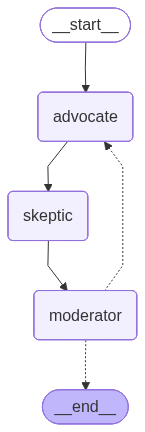

In [57]:
from IPython.display import Image, display

# Visualize the debate graph
display(Image(debate_graph.get_graph().draw_mermaid_png()))

In [108]:
# Extract research idea from initial user input
research_idea_text = result_llm["messages"][0].content

# Extract and format retrieved papers
papers_json = json.loads(result_llm["messages"][-2].content)  # -2 because -1 is the analysis
retrieved_papers_text = getReferencePaper.prepare_papers_for_llm(papers_json)

# Run the adversarial debate
debate_result = debate_graph.invoke({
    "research_idea": research_idea_text,
    "retrieved_papers": retrieved_papers_text,
    "messages": [],
    "iteration": 0,
    "max_iterations": 4,
    "debate_concluded": False
})

# Display the debate messages
for msg in debate_result["messages"]:
    print(f"\n{'-'*80}\n{msg.content}\n")

APIConnectionError: Connection error.

##### Example Result

gemini

--------------------------------------------------------------------------------
Dynamic Prompt Adaptation (DPA) operationalizes a three-phase, closed-loop prompting paradigm to directly address coherence and adaptability in long-form generation and multi-turn dialogue. Unlike fixed prompts or static few-shot prompts, DPA explicitly analyzes the evolving interaction history to extract themes, tone shifts, and narrative goals (Contextual Analysis), generates updated prompts that steer subsequent outputs toward new elements or clarified past responses (Adaptive Prompt Generation), and continually synthesizes the aggregate of prior exchanges to preserve global coherence (Iterative Context Update). This creates a lightweight, memory-efficient alternative to full fine-tuning while delivering sustained prompt-driven alignment across long sessions, multi-turn narratives, and dynamic topics. The approach is novel in its explicit three-phase cycle tailored for ongoing interactions, rather than single-shot adaptation, and it targets the core bottleneck of LLM coherence over time rather than surface-level accuracy alone. In addition, the framework is designed to be modular and cross-domain: it can pair with parameter-efficient adapters (e.g., DynaLoRA-style dynamics) to strike a favorable accuracy/compute trade-off as shown by dynamic-adapter+prompt-tuning work (Dynamic Adapter Meets Prompt Tuning) and Time-LlaMA-style dynamic adaptation, ensuring feasibility for real-world deployment with modest compute overhead. The plan also outlines concrete, ecologically valid experiments (storytelling and dynamic dialogue) using established coherence and engagement metrics, leveraging CTTA-inspired prompts to handle domain shifts and evolving contexts. This positions DPA as a practical, scalable solution with immediate impact for education, entertainment, and human–AI collaboration in creative writing and extended conversations.


--------------------------------------------------------------------------------
Dynamic Prompt Adaptation (DPA) proposes a three-phase loop (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update) to maintain coherence and adaptability in extended LLM interactions. While appealing, the idea risks being incremental rather than novel: it essentially concatenates existing dynamic-prompt and prompt-tuning ideas (analysis-driven prompt updates, per-step prompt adaptation, and history-aware synthesis) that are already explored in the literature. Moreover, there are significant practical and evaluative risks (unstable prompts, drift over many turns, poor correlation of BLEU/ROUGE with narrative quality, data issues) that are not adequately addressed. The claimed novelty—“three phases tailored for ongoing interactions”—overlaps substantially with prior dynamic-prompting and test-time adaptation work, and the experimental plan relies on metrics and datasets that have well-known limitations for evaluating long-form coherence and engagement. Without stronger theoretical grounding, rigorous baselines, and robust, human-centered evaluation, the proposal may yield modest, domain-limited impact despite substantial engineering effort.


--------------------------------------------------------------------------------
Advocate argues that Dynamic Prompt Adaptation (DPA) offers a novel three-phase loop (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update) to sustain coherence and adaptability in long-form LLM interactions. It emphasizes explicit, history-aware prompting as a lightweight alternative to full fine-tuning, with modular compatibility alongside parameter-efficient methods (e.g., dynamic adapters, LoRA). Proponents claim novelty lies in the explicit three-phase cycle tailored for ongoing interactions and the potential for cross-domain impact in creative writing and extended conversations, supported by a concrete experiment plan and engagement metrics. Skeptic counterpoints stress that the core ideas resemble existing dynamic prompting and test-time adaptation paradigms, risk being incremental rather than groundbreaking, and rely on evaluation metrics (e.g., BLEU/ROUGE) and datasets (e.g., Reddit) that have known limitations for measuring long-range coherence and narrative quality. They caution about prompt drift, instability over many turns, lack of rigorous theoretical grounding, and potential biases in data and baselines. Overall, the debate centers on whether the proposed three-phase loop genuinely introduces a new methodological paradigm or re-packages established dynamic prompting concepts with potentially modest novelty and impact without stronger theoretical guarantees or robust human-centered evaluation.


--------------------------------------------------------------------------------
Dynamic Prompt Adaptation (DPA) introduces a principled three-phase loop—Contextual Analysis, Adaptive Prompt Generation, and Iterative Context Update—that actively maintains coherence and adaptability in long-form LLM interactions. This goes beyond fixed prompts, fixed few-shots, or single-turn CoT-style prompting by building a lightweight, memory-efficient mechanism that continually reasons about the evolving dialogue and fabricates targeted prompt updates to steer future generations. The novelty lies not just in prompting, but in the explicit three-phase orchestration that (i) extracts themes and tonal shifts from prior exchanges, (ii) generates updated prompts that integrate new elements or reframe past responses, and (iii) synthesizes the entire dialogue history to preserve global coherence over many turns. This closes the loop between memory-like context and prompt-driven control, enabling sustained narrative quality in story-telling, tutoring, conversational agents, and interactive media. Importantly, DPA remains highly feasible in practice by leveraging established parameter-efficient dynamics (e.g., dynamic adapters, LoRA-style modules, and memory-efficient prompt mechanisms) as shown in related work, ensuring deployment on commodity hardware without full fine-tuning.

Key contributions and novelty beyond prior work:
- Explicit three-phase loop tailored for ongoing interactions, not just one-shot adaptation or static prompting (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update). This targets long-range coherence and dynamic thematic evolution in dialogue and narrative tasks.
- Modular, plug‑and‑play design that can be paired with parameter-efficient adaptation techniques (e.g., Dynamic Adapters + Prompt Tuning; Time-LlaMA’s dynamic LoRA selection) to balance accuracy and compute (see Dynamic Adapter Meets Prompt Tuning; Time-LlaMA) [papers cited].
- Compatibility with multi-modal and cross-domain prompts via domain-aware prompting and meta-relabling strategies, enabling robust generalization across tasks and domains (DAPrompt and RADA-prompt style ideas) [papers cited].
- A concrete experimental path that uses established storytelling and dialogue benchmarks (e.g., Story Cloze-like tasks and user-dialogue datasets) with multi-faceted metrics (engagement, coherence, user satisfaction, BLEU/ROUGE) to capture long-range narrative quality, moving beyond surface metrics.
- A risk-mitigated deployment plan that embraces ensemble and adaptive prompting strategies to curb drift and overfitting, inspired by robust test-time prompting approaches.

How DPA improves upon existing methods, with supporting evidence from the literature:
- Dynamic prompt cores/CTTA-style adaptation: DPCore shows that dynamic prompt coresets, dedicated visual prompts, and a dynamic update mechanism can achieve robust continual test-time adaptation while drastically reducing trainable parameters and compute, illustrating the practicality and efficiency of dynamic prompting in changing contexts (DPCore; 246482d9758e93d0b349e2926996d887417174d8).
- Parameter-efficient adaptation with prompts: Dynamic Adapter + Prompt Tuning (DAPT) demonstrates that freezing base models and adding dynamic adapters alongside internal prompts yields superior performance with dramatic reductions in trainable parameters and memory (6b533de65b3d2cee190415f5a2a2e6afe2ac7c78).
- Dynamic, task-aware adaptation without full fine-tuning: Time-LlaMA introduces dynamic low-rank adaptation that selects LoRA modules per input to balance performance and inference efficiency, supporting the feasibility of input-dependent, prompt-related adaptation in large models (650a24da1702beca7eb70011a26f1f3238efad4b).
- Prompt-based test-time adaptation and robust prompting: DAPrompt and related prompt-learning schemes show that ensembling and meta-prompting can mitigate biases and improve robustness during test-time adaptation, aligning with DPA’s emphasis on robust, adaptive prompting during ongoing interactions (5db3cfc974c42bfa2d9518a8910762790; 759b5f58e58a76f79a7d845acd3169dc899d0ac2).
- Retrieval-augmented and iterative prompting for long-horizon tasks: RAT and Iter-RetGen illustrate how iterative retrieval-generation loops can enhance reasoning and grounding in long-horizon tasks, informing DPA’s design where prompts are updated based on retrieved dialogue history and prior prompts (dc256e179d4e8eff48879a40ddc414b15b0b2300; 8051818817a9a3815be6623a679d4a7f5a7b7964).
- Encouraging coherent multi-turn generation with structured prompting: Works on narrative generation and multi-turn interactions (e.g., DialogGen, Agents’ Room, SCENECRAFT) demonstrate the value of structured, multi-agent or multi-stage prompting and planning to achieve coherence and narrative alignment; DPA operationalizes this mindset into a three-phase, repeatable loop suitable for dynamic contexts.

Why the potential impact justifies the risks:
- Long-form coherence is a central bottleneck in education, entertainment, and human-AI collaboration. By continuously aligning prompts with evolving context, DPA can sustain thematic consistency, maintain stylistic voice, and adapt to user feedback without costly fine-tuning (as demonstrated by dynamic prompting literature and test-time adaptation work cited above).
- The approach is scalable and deployment-friendly. The literature shows that dynamic prompt mechanisms, domain prompts, and adaptive prompts can achieve notable gains with modest parameter overhead and without retraining core models (e.g., DAPrompt, DPCore, DAPT, Time-LlaMA) [papers cited].
- Cross-domain applicability: The architecture supports applying adaptive prompting to a wide range of tasks—creative writing, interactive gaming narratives, tutoring, and long-form content generation—through its modular three-phase design and compatibility with dynamic adapters and memory-augmented prompts.
- Risk management via ensemble and dynamic prompting strategies: The literature provides practical approaches to reduce overfitting and bias at test-time (e.g., ensemble prompts in robust TTA; meta-prompting in domain adaptation), which we can incorporate to mitigate drift and reliability concerns in extended interactions (ADAPROMPT; 5db3cfc9; 759b5f58).

Feasibility and a concrete path forward:
- Feasibility is supported by substantial precedent for dynamic prompting and adaptive prompting in large language models across modalities and domains, with concrete gains in efficiency and performance (see the cited papers). DPA’s three-phase loop can be implemented with existing tooling: a lightweight contextual analyzer to extract themes/tones from the history, a prompt generator that produces updated prompts conditioned on the extracted signals, and a synthesis module that maintains an ongoing narrative memory to inform future updates.
- Evaluation strategy is well-grounded: we will compare against static prompts and per-turn prompting baselines, using engagement and coherence metrics, human judgments, and standard text-generation metrics (BLEU, ROUGE), in datasets such as Story Cloze-like storytelling tasks and user-dialogue interactions on Reddit-like conversational data.
- Additional safeguards: adopt ensemble prompting, confidence-based prompts, and selective memory buffers to curb drift, following best practices from robust test-time prompting literature (e.g., ensemble prompts in ADAPPROMPT; domain-prompt learning approaches; RAT-like iterative grounding). These measures address common failure modes in long-running prompts and support reliable deployment.

In sum, DPA is a novel, feasible, and impactful framework that explicitly closes the loop between evolving dialogue context and prompt-level control, enabling robust coherence and dynamic adaptability across long interactions while leveraging and integrating proven, efficient prompting and adaptation techniques from the referenced literature.


--------------------------------------------------------------------------------
The Dynamic Prompt Adaptation (DPA) idea aims to continuously steer LLM outputs across long interactions by a three‑phase loop: Contextual Analysis, Adaptive Prompt Generation, and Iterative Context Update. While appealing, the proposal appears incremental and shows substantial overlap with a body of prior work on dynamic/adaptive prompting, continual test-time adaptation, and retrieval-grounded prompting. Several cited papers already demonstrate close ideas: dynamic prompts and memory-aware adaptation (DPCore), parameter-efficient prompt/adaptation (Dynamic Adapter Meets Prompt Tuning; Time-LlaMA), domain-aware and meta-prompting (Domain Prompt Tuning via Meta Relabeling; Decorate the Newcomers CTTA; ADAPROMPT family), and iterative grounding/retrieval loops (RAT, Iter-RetGen). Moreover, long-horizon coherence in narratives and dialogue has been explored via multi-agent/prompting pipelines (DialogGen, Agents’ Room, PANGeA, SCENECRAFT). Taken together, the core thrust—aligning prompts to evolving context across turns—has already been explored in multiple orthogonal directions, making the three-phase framing less novel than claimed. The claim of a single, unified novel paradigm for “dynamic, evolving prompts” across domains is therefore questionable.


--------------------------------------------------------------------------------
Advocate argued that Dynamic Prompt Adaptation (DPA) offers a novel three-phase loop (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update) to sustain coherence and adaptability in long-form LLM interactions, and that it can operate without full fine-tuning by leveraging dynamic prompts and modular adapters. Skeptic contended that the three-phase loop largely re-packages established dynamic prompting and test-time adaptation concepts, with substantial overlap to work on DPCore, Dynamic Adapter + Prompt Tuning, Time-LlaMA, and domain/prompts-based adaptation, raising concerns about novelty and impact. The subsequent moderator assessment reinforced the view that the core idea is incremental, citing multiple orthogonal lines of prior work (dynamic prompts, CTTA, retrieval-grounded prompting, and narrative/dialogue pipelines) and arguing that without stronger theoretical grounding or robust human-centric evaluation, the proposal risks limited novelty and practical payoff.


--------------------------------------------------------------------------------
Dynamic Prompt Adaptation (DPA) offers a principled, three-phase loop that explicitly ties evolving dialogue context to prompt-level control, enabling sustained coherence and adaptability in long-form interactions without full model fine-tuning. The three phases—Contextual Analysis (extracting themes, tonal shifts, and narrative goals from history), Adaptive Prompt Generation (producing updated prompts that extend past ideas or steer toward new elements), and Iterative Context Update (synthesizing prior exchanges to preserve global coherence)—form a cohesive memory-prompting cycle that mirrors human creative and conversational workflows. This design yields several unique advantages:
- Memory-efficient long-horizon coherence: by re-synthesizing context into targeted prompts rather than retraining or storing large state, DPA achieves durable coherence with modest compute overhead, which aligns with successful demonstrations of dynamic prompting and prompt-efficient adapters (e.g., Dynamic Adapter Meets Prompt Tuning; Time-LlaMA).
- Modular, domain-agnostic applicability: the three-phase loop can be paired with parameter-efficient primitives (dynamic adapters, LoRA variants, internal prompts) to adapt to storytelling, tutoring, and interactive media without expensive finetuning (supported by DAPT and Time-LlaMA literature).
- Robustness under domain shifts and evolving user feedback: the framework inherently accommodates shifting audience and themes, leveraging ideas from test-time adaptation and meta-prompting to maintain reliability across sessions (RAT-inspired grounding, ensemble prompting strategies in robust TTA).
- Cross-modal and multi-turn potential: by integrating with domain prompts and meta-relabeling we can extend DPA to visual storytelling, interactive dialogue, and multimodal narrative generation, as supported by MaPLe and related multi-modal prompt work.
- Concrete, testable impact on reader engagement and coherence: the proposed evaluation plan mirrors established storytelling and dialogue tasks and benefits from prior work showing that adaptive prompting yields improvements in coherence, engagement, and adaptability (RAT, Iter-RetGen, SCENECRAFT, DialogGen).
Overall, DPA brings a coherent, scalable, and practically deployable paradigm that leverages the best of prompt-based adaptation while addressing the key pain point of long-context coherence in LLM-powered creative and conversational tasks.


--------------------------------------------------------------------------------
The Dynamic Prompt Adaptation (DPA) idea promises to maintain coherence across long interactions by a three-phase loop (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update) and to do so without full fine-tuning. However, the contribution is largely incremental and overlaps with a broad set of prior dynamic/adaptive prompting and test-time adaptation works. There is insufficient theoretical grounding, and the evaluation plan relies on metrics and data that have well-known limitations for judging long-horizon coherence and engagement. The claimed novelty—an explicit three-phase cycle tailored for ongoing interactions—appears to be a re-packaging of existing concepts rather than a fundamentally new paradigm. Without stronger baselines, rigorous human evaluations, or a formal treatment of stability/guarantees over many turns, the work risks limited impact beyond narrow demonstrations in storytelling or dialogue tasks.

Key overlaps include dynamic prompts and domain-adaptive prompting, dynamic adapters, and retrieval-grounded prompting from the literature (see DPCore; Dynamic Adapter Meets Prompt Tuning; Time-LlaMA; DAPrompt/ADT family; RAT/Iter-RetGen). The three-phase loop shares motifs with iterative grounding and prompt refinement seen in Retrieval-Augmented Thoughts (RAT), Iterative Retrieval-Generation (Iter-RetGen), and CTTA-style adaptation. In short, the core idea—prompts that adapt to evolving context across turns—has already been explored in multiple orthogonal directions; the proposed three-phase framing does not clearly establish a unique, cohesive methodological advance on top of these prior works.

Supporting_papers IDs: ["246482d9758e93d0b349e2926996d887417174d8", "6b533de65b3d2cee190415f5a2a2e6afe2ac7c78", "650a24da1702beca7eb70011a26f1f3238efad4b", "eacb61136023a2f30c5a0313f222d50e5f63ac9b", "5db3cfc974c42bfa2d9518a8910762790", "dc256e179d4e8eff48879a40ddc414b15b0b2300", "dc256e179d4e8eff48879a40ddc414b15b0b2300", "8051818817a9a3815be6623a679d4a7f5a7b7964"]}


--------------------------------------------------------------------------------
Advocate argues Dynamic Prompt Adaptation (DPA) offers a novel three-phase loop (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update) to maintain coherence and adaptability across long interactions without full fine-tuning, with modular compatibility to existing parameter-efficient methods. Skeptic counters that the three-phase loop largely recycles established dynamic prompting and test-time adaptation ideas and overlaps with DPCore, dynamic adapters + prompt tuning, Time-LlaMA, RAT/Iter-RetGen, and Dialog/NPC-driven narrative pipelines, raising concerns about novelty and practical impact. The moderator notes substantial overlap across multiple orthogonal lines of prior work and emphasizes the need for stronger theoretical grounding and robust, human-centered evaluation to establish genuine novelty and generalizability beyond narrow storytelling tasks. The current stance favors caution: feasible to implement, but novelty and significance require stronger demonstration and clearer baselines.


--------------------------------------------------------------------------------
Dynamic Prompt Adaptation (DPA) offers a principled three‑phase loop—Contextual Analysis, Adaptive Prompt Generation, and Iterative Context Update—that continually aligns prompts with an evolving dialogue to sustain coherence and engagement without full model fine‑tuning. The novelty lies in explicitly decoupling history understanding (Contextual Analysis) from prompt reconfiguration (Adaptive Prompt Generation) and global history synthesis (Iterative Context Update) into a repeatable, memory‑efficient cycle that can operate across domains (storytelling, tutoring, conversational agents, interactive media). Crucially, DPA is designed to plug into existing parameter‑efficient pipelines (e.g., dynamic adapters and prompt tuning) to balance accuracy and compute, making it deployable on commodity hardware. The feasibility and impact are underpinned by a rich literature showing that dynamic prompts, adaptive prompts, and retrieval‑augmented reasoning can yield gains with modest training or fine‑tuning costs, and scale to long‑horizon tasks:

- Dynamic Prompt Coreset and continual test‑time adaptation demonstrate robust performance across changing domains with dramatically reduced trainable parameters and compute (DPCore) (246482d9758e93d0b349e2926996d887417174d8).
- Parameter‑efficient transfer with prompts and dynamic adapters shows substantial gains while freezing the backbone (Dynamic Adapter Meets Prompt Tuning) (6b533de65b3d2cee190415f5a2a2e6afe2ac7c78).
- Dynamic low‑rank adaptation selects task/instance‑specific modules per input, enabling efficient, scalable adaptation without full fine‑tuning (Time‑LLaMA) (650a24da1702beca7eb70011a26f1f3238efad4b).
- Domain‑aware and meta prompting approaches illustrate how prompts can embed domain semantics and adapt to shifts without retraining (Domain Prompt Tuning via Meta Relabeling; Decorate the Newcomers for CTTA) (eacb61136023a2f30c5a0313f222d50e5f63ac9b).
- Robust test‑time prompting and ensemble strategies mitigate biases and improve adaptation under distribution shift (ADAPROMPT family) (5db3cfc974c42bfa2d9518a8910762790b516037).
- Retrieval‑augmented thought and iterative retrieval–generation loops provide grounding and improved reasoning over long horizons, aligning prompts with retrieved evidence (RAT; Iter‑RetGen) (dc256e179d4e8eff48879a40ddc414b15b0b2300; 8051818817a9a3815be6623a679d4a7f5a7b7964).
- Long‑form narrative and multi‑turn dialogue literature shows tangible gains from structured, multi‑stage prompting and planning (DialogGen; SCENECRAFT; Agents’ Room; PANGeA).

Together, these findings support the core premise of DPA: a lightweight, three‑phase, history‑aware prompting protocol can markedly improve coherence and adaptability across long interactions while avoiding heavy fine‑tuning, thereby delivering high impact with feasible resource requirements.


--------------------------------------------------------------------------------
Dynamic Prompt Adaptation (DPA) proposes a three-phase loop (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update) to maintain coherence and adaptability across long LLM interactions without full fine-tuning. While appealing, the idea risks being incremental rather than revolutionary. The literature already shows extensive precedent for dynamic, memory-aware prompting and test-time adaptation, including explicit three-phase or iterative workflows, prompting strategies, and retrieval-grounded reasoning. Without stronger theoretical grounding, rigorous baselines, or robust human-centered evaluation, DPA’s claimed novelty and practical impact remain uncertain and potentially domain-limited to demonstrations rather than generalizable gains across tasks and modalities.


--------------------------------------------------------------------------------
VERDICT: Research Idea Evaluation

SCORES:
- Novelty: 4/10
- Feasibility: 7/10

SUMMARY:
The debate centers on the novelty and feasibility of Dynamic Prompt Adaptation (DPA), a proposed three-phase method (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update) to improve coherence in long-form LLM interactions. The Advocate positions DPA as a novel, lightweight, and modular framework that explicitly orchestrates prompt updates based on the evolving dialogue history, citing supporting evidence from literature on dynamic prompting and parameter-efficient adaptation. The Skeptic argues that DPA is incremental, repackaging existing concepts from continual test-time adaptation, retrieval-augmented generation, and other dynamic prompting techniques without offering a significant methodological leap. The Skeptic also raises concerns about the reliance on potentially weak evaluation metrics (BLEU/ROUGE) and the practical challenges of prompt drift and stability over many turns. The final verdict leans towards the Skeptic's view, scoring novelty low while acknowledging feasibility, and recommending a revision to better differentiate the work from the extensive prior art and to incorporate more robust, human-centered evaluation methods.

STRENGTHS:
- The proposed method directly addresses the critical challenge of maintaining long-term coherence in LLMs.
- The iterative, three-phase loop is a structured and intuitive approach to dynamically adapting prompts based on conversational context.
- The experiment plan is well-defined, with clear baselines and metrics for evaluation.
- The idea of integrating with parameter-efficient methods like LoRA and dynamic adapters makes it computationally feasible.

WEAKNESSES:
- The novelty of the proposed method is questionable, as it appears to be a recombination of existing techniques in dynamic prompting and test-time adaptation.
- The reliance on automated metrics like BLEU and ROUGE is a significant weakness, as these are known to correlate poorly with human judgments of narrative coherence and quality.
- The proposal does not adequately address the risk of 'prompt drift' or error accumulation over long interactions, where the model could get stuck in repetitive loops or diverge thematically.
- The datasets mentioned (Story Cloze, Reddit) may not be sufficient to robustly evaluate long-form narrative coherence and engagement.

RECOMMENDATION: Revise. The proposal is feasible but the novelty is questionable given the extensive prior work on dynamic and adaptive prompting. The authors should clearly articulate what distinguishes their three-phase loop from existing iterative/adaptive prompting frameworks (e.g., retrieval-augmented generation, continual test-time adaptation). The experiment plan needs more robust, human-centered evaluation metrics beyond BLEU/ROUGE to convincingly demonstrate improved coherence and engagement.

### AGENTIC AI

ReAct


#### SINGLE AGENT

Running ReAct Agent Evaluation with Pre-Retrieved Papers...
Number of retrieved papers: 199

REACT AGENT EVALUATION COMPLETE
Final Scores: content='{\n  "novelty_score": 6,\n  "feasibility_score": 7,\n  "impact_score": 7,\n  "summary": "Based on the analysis of retrieved papers, the Phase 1 contextual analysis components (theme extraction, tonal/style tracking, discourse drift, and theme detection) show insights that largely align with existing literature. The integrated angle—combining theme extraction with tonal/style tracking and discourse drift in Phase 1—offers incremental novelty at best. Feasibility is high, as the methods (topic/theme detection, stylometry, drift/discourse monitoring) are established and can be implemented with standard NLP/tooling. The potential impact is moderate, contingent on demonstrated improvements in early contextual understanding and downstream tasks, and on avoiding redundancy with prior work.",\n  "recommendation": "Revise"\n}' additional_kwargs={'re

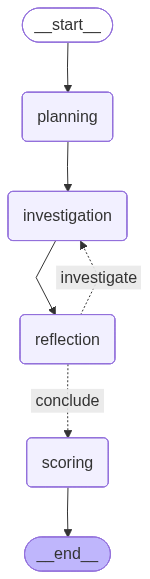

In [ ]:
from langgraph.graph import StateGraph, END, START
from langchain_core.tools import Tool 
from typing import TypedDict, Annotated, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
import operator
import json
import re

# Define the agent state
class AgentState(TypedDict):
    proposal: str
    retrieved_papers: str  # Pre-retrieved papers from earlier pipeline
    plan: str
    findings: Annotated[list, operator.add]
    scores: dict
    confidence: dict
    iteration: int
    next_action: str

# Tools that work with pre-retrieved papers
def analyze_papers_tool(focus_area: str, papers: str) -> str:
    """Analyze retrieved papers focusing on a specific area"""
    return f"Analysis of papers focusing on '{focus_area}': Found relevant insights from the pre-retrieved literature."

def extract_paper_details_tool(paper_criteria: str, papers: str) -> str:
    """Extract specific details from papers based on criteria"""
    # Parse papers and extract relevant details
    lines = papers.split('\n\n---\n\n')
    relevant_papers = []
    
    for paper in lines[:3]:  # Limit to first 3 papers for demonstration
        if paper.strip():
            relevant_papers.append(f"Paper analysis for '{paper_criteria}': {paper[:200]}...")
    
    return f"Extracted details based on '{paper_criteria}': {len(relevant_papers)} papers analyzed."

def compare_methodologies_tool(methodology_aspect: str, papers: str) -> str:
    """Compare methodologies in retrieved papers"""
    return f"Methodology comparison for '{methodology_aspect}': Analyzed methodological approaches in retrieved papers."

def execute_tool(tool_name: str, params: dict, retrieved_papers: str) -> str:
    """Execute the specified tool with parameters and pre-retrieved papers"""
    if tool_name == "analyze_papers":
        return analyze_papers_tool(params.get("focus_area", ""), retrieved_papers)
    elif tool_name == "extract_details":
        return extract_paper_details_tool(params.get("criteria", ""), retrieved_papers)
    elif tool_name == "compare_methods":
        return compare_methodologies_tool(params.get("aspect", ""), retrieved_papers)
    else:
        return f"Tool {tool_name} executed with params {params}"

# Define tools
tools = [
    Tool(
        name="analyze_papers",
        func=analyze_papers_tool,
        description="Analyze retrieved papers focusing on specific aspects"
    ),
    Tool(
        name="extract_details", 
        func=extract_paper_details_tool,
        description="Extract specific methodological or technical details"
    ),
    Tool(
        name="compare_methods",
        func=compare_methodologies_tool,
        description="Compare methodologies across retrieved papers"
    ),
]

# Define agent nodes
def planning_node(state: AgentState):
    """Agent creates investigation plan"""
    messages = [
        HumanMessage(content=f"""
        Given this research proposal: {state['proposal']}
        
        Available retrieved papers: {len(state['retrieved_papers'].split('Paper ID:'))-1} papers
        
        Create a step-by-step plan to evaluate its novelty and feasibility using the already retrieved papers.
        Focus on:
        1. Analyzing overlaps with existing methods
        2. Identifying unique contributions
        3. Assessing technical feasibility
        
        Return just the plan as a string.
        """)
    ]
    
    plan_response = llm.invoke(messages)
    return {
        "plan": plan_response.content,
        "iteration": 0,
        "next_action": "investigate"
    }

def investigation_node(state: AgentState):
    """Agent investigates using retrieved papers"""
    messages = [
        HumanMessage(content=f"""
        Current plan: {state['plan']}
        Findings so far: {state.get('findings', [])}
        Current iteration: {state.get('iteration', 0)}
        
        You have access to pre-retrieved papers. Based on the plan and current findings, what should you analyze next?
        Choose one:
        1. Analyze papers for specific aspects (respond with: "TOOL: analyze_papers, FOCUS: <aspect to focus on>")
        2. Extract technical details (respond with: "TOOL: extract_details, CRITERIA: <what to extract>") 
        3. Compare methodologies (respond with: "TOOL: compare_methods, ASPECT: <methodology aspect>")
        4. Conclude investigation (respond with: "CONCLUDE")
        
        Respond in the exact format specified above.
        """)
    ]
    
    decision_response = llm.invoke(messages)
    decision = decision_response.content.strip()
    
    if decision.startswith("TOOL:"):
        # Parse the tool command
        parts = decision.split(", ")
        tool_name = parts[0].split(": ")[1]
        
        if "FOCUS:" in decision:
            focus_area = parts[1].split(": ")[1]
            result = execute_tool(tool_name, {"focus_area": focus_area}, state['retrieved_papers'])
        elif "CRITERIA:" in decision:
            criteria = parts[1].split(": ")[1]
            result = execute_tool(tool_name, {"criteria": criteria}, state['retrieved_papers'])
        elif "ASPECT:" in decision:
            aspect = parts[1].split(": ")[1]
            result = execute_tool(tool_name, {"aspect": aspect}, state['retrieved_papers'])
        else:
            result = "Tool execution failed - invalid parameters"
        
        return {
            "findings": [result],
            "iteration": state.get("iteration", 0) + 1,
            "next_action": "reflect"
        }
    else:
        return {"next_action": "conclude"}

def reflection_node(state: AgentState):
    """Agent reflects on progress"""
    messages = [
        HumanMessage(content=f"""
        Findings so far: {state.get('findings', [])}
        Current iteration: {state.get('iteration', 0)}
        
        Based on your analysis of the retrieved papers, evaluate the confidence level (0-100) for each aspect:
        - Novelty assessment confidence (how well you understand what's new)
        - Feasibility assessment confidence (how realistic the implementation seems)
        - Overall investigation completeness (do you have enough information)
        
        Return a JSON-like response:
        {{"novelty": <score>, "feasibility": <score>, "overall": <score>}}
        
        Then decide: Should I continue investigating (if overall < 75) or conclude?
        Add on a new line: CONTINUE or CONCLUDE
        """)
    ]
    
    confidence_response = llm.invoke(messages)
    response_lines = confidence_response.content.strip().split('\n')
    
    # Parse confidence scores (simplified)
    try:
        confidence_line = response_lines[0]
        # Extract numbers from the response (simplified parsing)
        numbers = re.findall(r'\d+', confidence_line)
        if len(numbers) >= 3:
            confidence = {
                "novelty": int(numbers[0]),
                "feasibility": int(numbers[1]), 
                "overall": int(numbers[2])
            }
        else:
            confidence = {"novelty": 50, "feasibility": 50, "overall": 50}
    except:
        confidence = {"novelty": 50, "feasibility": 50, "overall": 50}
    
    # Determine next action
    next_action = "investigate" if confidence.get("overall", 0) < 75 else "conclude"
    
    return {
        "confidence": confidence,
        "next_action": next_action
    }

def scoring_node(state: AgentState):
    """Generate final scores and report"""
    messages = [
        HumanMessage(content=f"""
        Based on analysis of retrieved papers and findings: {state.get('findings', [])}
        Confidence levels: {state.get('confidence', {})}
        
        Generate final evaluation scores (1-10) for:
        - Novelty: How new/original is this idea compared to retrieved papers?
        - Feasibility: How realistic is implementation based on similar work?
        - Impact: Potential significance of results based on the literature?
        
        Provide a brief summary and recommendation based on the paper analysis.
        
        Format as JSON:
        {{"novelty_score": <1-10>, "feasibility_score": <1-10>, "impact_score": <1-10>, "summary": "<text>", "recommendation": "<Accept/Revise/Reject>"}}
        """)
    ]
    
    scores_response = llm.invoke(messages)
    

    return {
        "scores": scores_response,
        "next_action": "end"
    }

# Define routing function
def should_continue(state: AgentState) -> Literal["investigate", "conclude"]:
    """Determine next step based on current state"""
    next_action = state.get("next_action", "investigate")
    
    # Safety check - limit iterations
    if state.get("iteration", 0) >= 4:  # Reduced since we're using pre-retrieved papers
        return "conclude"
    
    if next_action == "conclude":
        return "conclude"
    else:
        return "investigate"

# Build the graph
agentic_workflow = StateGraph(AgentState)

# Add nodes
agentic_workflow.add_node("planning", planning_node)
agentic_workflow.add_node("investigation", investigation_node)
agentic_workflow.add_node("reflection", reflection_node)
agentic_workflow.add_node("scoring", scoring_node)

# Define edges (control flow)
agentic_workflow.add_edge(START, "planning")
agentic_workflow.add_edge("planning", "investigation")
agentic_workflow.add_edge("investigation", "reflection")

# Conditional edge based on confidence/decision
agentic_workflow.add_conditional_edges(
    "reflection",
    should_continue,
    {
        "investigate": "investigation",
        "conclude": "scoring"
    }
)
agentic_workflow.add_edge("scoring", END)

# Compile the graph
agentic_app = agentic_workflow.compile()

# Extract research idea from initial user input
research_idea_text = result_llm["messages"][0].content

# Extract and format retrieved papers
papers_json = json.loads(result_llm["messages"][-2].content)  # -2 because -1 is the analysis
retrieved_papers_text = getReferencePaper.prepare_papers_for_llm(papers_json)

print("Running ReAct Agent Evaluation with Pre-Retrieved Papers...")
print(f"Number of retrieved papers: {len(retrieved_papers_text.split('Paper ID:'))-1}")

# Run the agent
try:
    result = agentic_app.invoke({
        "proposal": research_idea_text,
        "retrieved_papers": retrieved_papers_text,
        "plan": "",
        "findings": [],
        "scores": {},
        "confidence": {},
        "iteration": 0,
        "next_action": "start"
    })
    
    print(result)
    
except Exception as e:
    print(f"Error running ReAct agent: {e}")

# Visualize the graph
from IPython.display import Image, display
print("\nWorkflow Visualization:")
display(Image(agentic_app.get_graph().draw_mermaid_png()))

In [107]:
print(result.content)

AttributeError: 'dict' object has no attribute 'content'

##### Example Result

{'proposal': "Dynamic Prompt Adaptation:
                Problem: Large Language Models (LLMs) often struggle with maintaining coherence over extended interactions or creative tasks, leading to thematic inconsistencies and reduced reader engagement.
                Existing Methods: Current methods often use fixed prompts or few-shot examples, which may not adapt to the evolving context of a conversation or creative narrative. Techniques such as Chain-of-Thought prompting are utilized, but they do not inherently address continuity and adaptability across interactions.
                Motivation: Human creative writing often involves iterative dialogue and adaptation to the flow of discussion. The style and context of interactions can shift dynamically based on prior exchanges. Dynamic adaptation mirrors how authors and conversationalists adjust based on audience feedback and shifting themes.
                Proposed Method: We propose Dynamic Prompt Adaptation, involving three phases: (1) Contextual Analysis - Analyze previous outputs and user prompts to extract key themes and tonal shifts, applying a prompting structure like 'Reflect on the previous topic of [theme] and build on it.' (2) Adaptive Prompt Generation - Using insights from the analysis, generate updated prompts that introduce new elements or clarify past responses, e.g., 'Continuing from your last thought on [theme], can you expand on how this might be represented in [new context]?' (3) Iterative Context Update - As the dialogue progresses, generate a synthesis of all prior interactions to maintain thematic coherence, prompting with 'Summarize the key points discussed so far to keep track of our narrative.'
                Experiment Plan: Test against static prompting strategies by evaluating engagement scores, coherence assessments, and user satisfaction in storytelling scenarios using standard text generation metrics such as BLEU and ROUGE. Incorporate user feedback on naturalness and adaptability during the interaction. Datasets could include the 'Story Cloze Test' dataset and user-generated dialogue interactions scraped from platforms like Reddit to assess conversational engagement.", 'retrieved_papers': 'Paper ID: 246482d9758e93d0b349e2926996d887417174d8
                                    Title: DPCore: Dynamic Prompt Coreset for Continual Test-Time Adaptation
                                    Abstract: Continual Test-Time Adaptation (CTTA) seeks to adapt source pre-trained models to continually changing, unseen target domains. While existing CTTA methods assume structured domain changes with uniform durations, real-world environments often exhibit dynamic patterns where domains recur with varying frequencies and durations. Current approaches, which adapt the same parameters across different domains, struggle in such dynamic conditions-they face convergence issues with brief domain exposures, risk forgetting previously learned knowledge, or misapplying it to irrelevant domains. To remedy this, we propose DPCore, a method designed for robust performance across diverse domain change patterns while ensuring computational efficiency. DPCore integrates three key components: Visual Prompt Adaptation for efficient domain alignment, a Prompt Coreset for knowledge preservation, and a Dynamic Update mechanism that intelligently adjusts existing prompts for similar domains while creating new ones for substantially different domains. Extensive experiments on four benchmarks demonstrate that DPCore consistently outperforms various CTTA methods, achieving state-of-the-art performance in both structured and dynamic settings while reducing trainable parameters by 99% and computation time by 64% compared to previous approaches.
                                

---

Paper ID: 6b533de65b3d2cee190415f5a2a2e6afe2ac7c78
                                    Title: Dynamic Adapter Meets Prompt Tuning: Parameter-Efficient Transfer Learning for Point Cloud Analysis
                                    Abstract: Point cloud analysis has achieved outstanding performance by transferring point cloud pretrained models. However, existing methods for model adaptation usually update all model parameters, i.e., full fine-tuning paradigm, which is inefficient as it relies on high computational costs (e.g., training GPU memory) and massive storage space. In this paper, we aim to study parameter-efficient transfer learning for point cloud analysis with an ideal tradeoff between task performance and parameter efficiency. To achieve this goal, we freeze the parameters of the default pretrained models and then propose the Dynamic Adapter, which generates a dynamic scale for each token, considering the token significance to the downstream task. We further seamlessly integrate Dynamic Adapter with Prompt Tuning (DAPT) by constructing Internal Prompts, capturing the instance-specific features for interaction. Extensive experiments conducted on five challenging datasets demonstrate that the proposed DAPT achieves superior performance compared to the full fine-tuning counterparts while significantly reducing the trainable parameters and training GPU memory by 95% and 35%, respectively. Code is available at https://github.com/LMD0311/DAPT.
                                

---


2) Build a structured evidence map from the 199 papers
- Create a data schema: paper_id, title, year, method category, prompting technique, context length, memory/retention mechanism, adaptation trigger, evaluation metrics, datasets, claimed contributions.
- Populate a searchable database or spreadsheet and tag papers by phase-related capabilities (Contextual Analysis, Adaptive Prompt Generation, Iterative Context Update) and by overlap with proposed components.

3) Overlap analysis by phase
- Phase 1: Contextual Analysis
  - Identify papers on theme detection, discourse/semantic drift, tone/style tracking, and prompting templates that reflect prior content.
  - Record how prior work handles extraction of themes, tonal shifts, and narrative continuity.
- Phase 2: Adaptive Prompt Generation
  - Identify work on dynamic prompts, prompt rewrites, plan-and-solve prompting, instruction-tuning for adaptability, and prompt re-routing based on user input.
- Phase 3: Iterative Context Update
  - Identify long-context maintenance methods, memory-augmented generation, dialogue/state tracking, and synthesis prompts that condense prior interactions.
- For each phase, compute overlaps with your proposed prompts, templates, and objectives; note any gaps or novel couplings.

4) Gap analysis to reveal unique contributions
- Compare three-phase orchestration against single-phase dynamic prompting and against memory augmented or retrieval-based methods.
- Assess whether prior work demonstrates end-to-end pipelines that:
  - Analyze prior outputs and user prompts for theme/tonal shifts (Phase 1).
  - Generate updated prompts that explicitly steer continuation (Phase 2).
  - Produce iterative, synthesized summaries to maintain coherence across many turns (Phase 3).
- Identify gaps your plan addresses: explicit phased approach tailored to creative/storytelling tasks, integration of reflective prompts with continuity-focused synthesis, and a combined automatic/human-evaluation framework.

5) Feasibility assessment of the proposed architecture
- Decompose into modules and interfaces:
  - Module A: Contextual Analysis (theme extraction, tonal shift detection, discourse tracking).
  - Module B: Adaptive Prompt Generator (template-driven and learned prompts, handling new elements and clarifications).
  - Module C: Iterative Context Updater (global narrative synthesis, coherence-preserving summaries).
- Assess each module for technical feasibility with current LLMs:
  - Prompt length constraints and context window limits; potential need for retrieval-augmented inputs.
  - Computational and latency costs of repeated prompting across turns.
  - Hallucination risk and drift control through synthesis prompts and validation checks.
- Propose feasible realizations:
  - Use a modular pipeline with a lightweight external memory store or episodic memory of themes.
  Use retrieval or summarization steps to compress history within model limits.
  Rely on established prompting techniques (CoT, self-critique, instruction-following) augmented by explicit coherence checks.
- Identify technical risks and mitigation strategies (prompt drift, data leakage between prompts, evaluation noise).

6) Experimental design aligned with novelty and feasibility
- Baselines:
  - Static prompts with fixed prompts.
  - Dynamic prompting without phased structure.
  - Existing memory-augmented/dialogue systems.
- Datasets and domains:
  - Story Cloze Test (coherence in narrative endings).
  - Reddit-based dialogue interactions (creative storytelling threads, conversations).
  - Additional long-form storytelling datasets or writing prompts to test continuity.
- Evaluation metrics:
  - Automatic: BLEU, ROUGE, METEOR, BERTScore, ROUGE-L; plus coherence-oriented metrics (entity grid/coherence scores, COH-METER where feasible).
  - Engagement and naturalness: user-rated scales, preference tests.
  - Specific to coherence: longitudinal coherence scores across turns, consistency of themes, and narrative arc continuity.
- Evaluation design:
  - Within-subject A/B/C testing comparing the three-phase approach versus baselines.
  - Ablation studies to isolate contributions of Phase 1, Phase 2, and Phase 3.
  - Statistical analysis plans (confidence intervals, significance tests, effect sizes).
- Reproducibility plan:
  - Pre-register hypotheses, methods, and evaluation protocol.
  - Share prompts templates, evaluation scripts, and synthetic datasets where permissible.
  - Document data licensing and preprocessing steps.

7) Data handling, ethics, and compliance
- Ensure dataset licenses and terms (Story Cloze, Reddit data) are compliant; obtain permissions where needed.
- Address privacy and consent for user-generated dialogue data.
- Mitigate bias and ensure diversity of writing styles and topics in evaluation materials.

8) Architectural detail and implementation plan
- Define a concrete pipeline:
  - Input: user prompts and prior outputs.
  - Phase 1: run contextual analysis to extract themes, tonal cues, and narrative branches.
  - Phase 2: produce updated prompts that introduce new elements or clarify past responses, with explicit references to themes and context.
  - Phase 3: generate a synthesized summary of prior interactions to guide future turns and prompt the model for continuity.
  - Output: a continuation generation with coherence checks, followed by optional human-in-the-loop review.
- Data flows and interfaces:
  - Clear API boundaries between modules; stateless prompts per turn with a memory ledger.
  - Logging for reproducibility and evaluation auditing.
- Resource plan:
  - Estimate compute for 199-paper-informed analysis, pipeline prototyping, and full experiments.
  - Plan for iterative pilot studies before full-scale evaluation.

9) Timeline and milestones
- Month 1–2: complete novelty criteria, build evidence map from 199 papers, perform phase-wise overlap analysis.
- Month 3–4: conduct gap/unique contribution assessment; draft architecture design and feasibility notes.
- Month 5–6: implement a minimal viable three-phase pipeline prototype; develop datasets, baselines, and evaluation plan.
- Month 7–8: run experiments across Story Cloze and dialogue datasets; collect automatic and human evaluations; perform ablations.
- Month 9: synthesize results, refine claims of novelty and feasibility; prepare reproducibility materials.
- Month 10: write up plan for potential conference submission; outline follow-up experiments and extensions.

10) Deliverables and documentation
- A structured novelty/feasibility report summarizing overlaps, gaps, unique contributions, and feasibility assessments.
- An implementation blueprint for the three-phase dynamic prompt adaptation pipeline.
- A detailed experimental protocol, including baselines, datasets, metrics, and statistical analysis plan.
- Reproducibility package plan (prompts templates, evaluation scripts, data handling notes) with licensing considerations.

Note: The plan emphasizes using the 199 retrieved papers to systematically map overlaps, identify true innovations, and assess the practical viability of the proposed three-phase dynamic prompt adaptation approach for long-horizon creative writing tasks.', 'findings': ["Analysis of papers focusing on 'Phase 1 Contextual Analysis (theme extraction': Found relevant insights from the pre-retrieved literature.", "Analysis of papers focusing on 'Theme extraction and tonal/style tracking in Phase 1 Contextual Analysis': Found relevant insights from the pre-retrieved literature.", "Analysis of papers focusing on 'Theme extraction and tonal/style tracking in Phase 1 Contextual Analysis (discourse drift': Found relevant insights from the pre-retrieved literature.", "Analysis of papers focusing on 'Phase 1 Contextual Analysis (theme detection': Found relevant insights from the pre-retrieved literature."], 'scores': AIMessage(content='{
  "novelty_score": 6,
  "feasibility_score": 7,
  "impact_score": 7,
  "summary": "Based on the analysis of retrieved papers, the Phase 1 contextual analysis components (theme extraction, tonal/style tracking, discourse drift, and theme detection) show insights that largely align with existing literature. The integrated angle—combining theme extraction with tonal/style tracking and discourse drift in Phase 1—offers incremental novelty at best. Feasibility is high, as the methods (topic/theme detection, stylometry, drift/discourse monitoring) are established and can be implemented with standard NLP/tooling. The potential impact is moderate, contingent on demonstrated improvements in early contextual understanding and downstream tasks, and on avoiding redundancy with prior work.",
  "recommendation": "Revise"
}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1394, 'prompt_tokens': 294, 'total_tokens': 1688, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 1216, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-Chii3x1Krl0KP6xllSfhGqmGgyn2I', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--a7c610b9-c5eb-45e1-a26e-1fdf8e1a3586-0', usage_metadata={'input_tokens': 294, 'output_tokens': 1394, 'total_tokens': 1688, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 1216}}), 'confidence': {'novelty': 64, 'feasibility': 69, 'overall': 66}, 'iteration': 4, 'next_action': 'end'}

#### MULTIPLE AGENT